<a href="https://colab.research.google.com/github/reshalfahsi/neuralnetwork/blob/main/notebook/NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Install Package**

In [ ]:
!git clone https://github.com/reshalfahsi/neuralnetwork
%cd neuralnetwork
!pip install -q .

## **Hyperparameters**

In [31]:
NUM_EPOCHS = 32
BATCH_SIZE = 16
lr = 1e-2

## **Dataset Preparation**

This tutorial will use a toy dataset from [MedMNIST](https://medmnist.com/). We use PneumoniaMNIST, which contains 2D X-ray image-label pairs for distinguishing between Pneumonia-infected and healthy lungs. The pneumonia-infected lung is denoted by the label `1` whilst the healthy lung is labeled as `0`.

In [32]:
from neuralnetwork.ds.medmnist import PneumoniaMNIST
from neuralnetwork import ds
import numpy as np


train_dataset = PneumoniaMNIST(split='train', download=True)
test_dataset = PneumoniaMNIST(split='test', download=True)

print("Train Dataset:", len(train_dataset))
print("Test Dataset", len(test_dataset))

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Train Dataset: 4708
Test Dataset 624


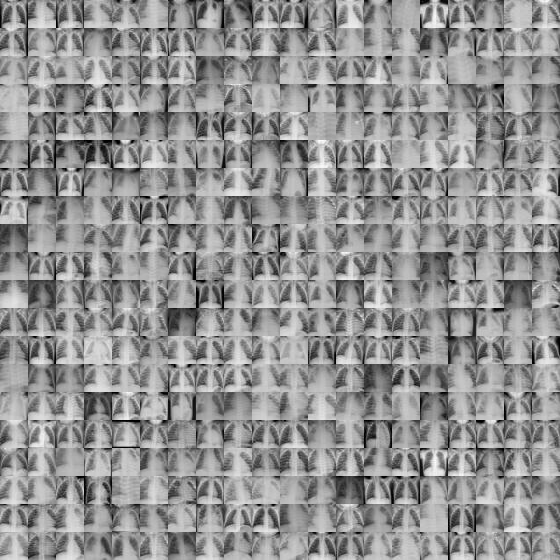

In [33]:
train_dataset.montage(length=20)

## **Neural Network**

The artificial neural network is a bio-inspired machine learning method that models neuronal signal propagation by matrix multiplication. Here we have two kinds of neuronal signal propagation: forward propagation and backward propagation. In forward propagation, the neuron actively conveys information from the "receptor" (or input) to the "central nervous system" (or output). Backward propagation or backpropagation, in short, is utilized in the training or learning process. In the learning process, the neural network transmits error gradients from the "central nervous system" to the "receptor". For further knowledge about the learning process, read more: [Calculus on Computational Graphs: Backpropagation](https://colah.github.io/posts/2015-08-Backprop/) and [Backpropagation for a Linear Layer
](https://web.eecs.umich.edu/~justincj/teaching/eecs442/notes/linear-backprop.html).

In [34]:
import neuralnetwork.nn as nn


class NeuralNetwork(nn.Module):
    def __init__(self, **kwargs):
        super(NeuralNetwork, self).__init__(**kwargs)
        self.linear0 = nn.Linear(784, 200, **kwargs)
        self.linear1 = nn.Linear(200, 200, **kwargs)
        self.linear2 = nn.Linear(200, 1, **kwargs)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        self.out0 = self.linear0(x)
        self.out1 = self.sigmoid(self.out0)
        self.out2 = self.linear1(self.out1)
        self.out3 = self.sigmoid(self.out2)
        self.out4 = self.linear2(self.out3)
        self.out5 = self.sigmoid(self.out4)

        return self.out5
    
    def backward(self, lr, criterion, method=None):
                                                               # Computational Graph
                                                               #
        self.dx0 = criterion.grad()                            # loss_grad(pred, y)
                                                               #        |
        self.dx1 = self.sigmoid.grad(self.out4)                # sigmoid_grad(pred)
                                                               #        |
                                                               #        +
                                                               #       / \
                                                               #      |   |
                                                               #  b_grad  *
                                                               #         / \
                                                               #        |   |
        self.dx2 = self.linear2.grad(self.dx1 * self.dx0)      #   A_grad   x_grad
                                                               #          .
        self.dx3 = self.sigmoid.grad(self.out2)                #          .
        self.dx4 = self.linear1.grad(self.dx3 * self.dx2)      #          .

        self.dx5 = self.sigmoid.grad(self.out0)
        self.dx6 = self.linear0.grad(self.dx5 * self.dx4)

        #-----------------------------------------------------

        self.d2x0 = criterion.grad('hessian')                                                        
        self.d2x1 = self.sigmoid.grad(self.out4, 'hessian')

        gradient = {
            'error_first': self.dx0,
            'error_second': self.d2x0,
            'nonlinearity_first': self.dx1,
            'nonlinearity_second': self.d2x1,
        }               

        self.d2x2 = self.linear2.grad(gradient, 'hessian')
        self.d2x3 = self.sigmoid.grad(self.out2, 'hessian') 

        gradient = {
            'error_first': self.dx2,
            'error_second': self.d2x2,
            'nonlinearity_first': self.dx3,
            'nonlinearity_second': self.d2x3,
        }         
                                                                           
        self.d2x4 = self.linear1.grad(gradient, 'hessian')
        self.d2x5 = self.sigmoid.grad(self.out0, 'hessian')

        gradient = {
            'error_first': self.dx4,
            'error_second': self.d2x4,
            'nonlinearity_first': self.dx5,
            'nonlinearity_second': self.d2x5,
        } 

        self.d2x6 = self.linear0.grad(gradient, 'hessian')

        #-----------------------------------------------------

        self.linear0.update(lr, method)
        self.linear1.update(lr, method)
        self.linear2.update(lr, method)

## **Training**

In [35]:
import time	


def accuracy(model, X, Y):
    pred = model(X)
    pred = pred > 0.5
    acc = np.sum(pred == Y)
    acc = acc / Y.shape[0]
    return acc

seed = np.random.randint(2147483647)
print(seed)

1747906812


### **Gradient Descent**

In [36]:
train_loader = ds.get_loader(dataset=train_dataset, batch_size=BATCH_SIZE)
test_loader = ds.get_loader(dataset=test_dataset, batch_size=1)

criterion = nn.MSELoss()
np.random.seed(seed)
model = NeuralNetwork()


start = time.perf_counter()
for epoch in range(NUM_EPOCHS):
    loss = list()
    acc = list()
    for idx, pack in enumerate(train_loader):
        x, y = pack
        bs = x.shape[0]
        L = x.shape[1] * x.shape[2]
        x = x.reshape(bs, 1, L) / 255.0
        y = y.reshape(bs, 1, 1)
        pred = model(x)
        loss.append(criterion(pred, y))
        model.backward(lr, criterion)
        acc.append(accuracy(model, x, y))
        if idx % 20 == 0 or idx == len(train_dataset) - 1:
            print(
                "{}/{} - The training loss at {}th epoch : {}  Training Accuracy:{}".format(
                    idx + 1,
                    len(train_dataset) // BATCH_SIZE,
                    epoch,
                    np.array(loss).mean(),
                    np.array(acc).mean(),
                ),
            )
        if idx >= int(len(train_dataset) / BATCH_SIZE) - 1:
            break

    if np.array(acc).mean() > 0.9:
        break
    print("-----------------------------------------------------------")
end = time.perf_counter()

print(f"Training finished in {epoch + 1} epochs and {end - start:0.4f} seconds")

Size 4708
1/294 - The training loss at 0th epoch : 0.8124369466739678  Training Accuracy:0.1875
21/294 - The training loss at 0th epoch : 0.7320028422410736  Training Accuracy:0.26785714285714285
41/294 - The training loss at 0th epoch : 0.7651385959246129  Training Accuracy:0.2347560975609756
61/294 - The training loss at 0th epoch : 0.7642503744823572  Training Accuracy:0.23565573770491804
81/294 - The training loss at 0th epoch : 0.7545432631624941  Training Accuracy:0.24537037037037038
101/294 - The training loss at 0th epoch : 0.7468243621063443  Training Accuracy:0.2530940594059406
121/294 - The training loss at 0th epoch : 0.742166769899559  Training Accuracy:0.2577479338842975
141/294 - The training loss at 0th epoch : 0.7419384884002742  Training Accuracy:0.2579787234042553
161/294 - The training loss at 0th epoch : 0.7409922954347798  Training Accuracy:0.25892857142857145
181/294 - The training loss at 0th epoch : 0.743360825802488  Training Accuracy:0.256560773480663
201/294

### **Newton Method**

In [37]:
train_loader = ds.get_loader(dataset=train_dataset, batch_size=BATCH_SIZE)
test_loader = ds.get_loader(dataset=test_dataset, batch_size=1)

criterion = nn.MSELoss()
np.random.seed(seed)
model = NeuralNetwork()


start = time.perf_counter()
for epoch in range(NUM_EPOCHS):
    loss = list()
    acc = list()
    for idx, pack in enumerate(train_loader):
        x, y = pack
        bs = x.shape[0]
        L = x.shape[1] * x.shape[2]
        x = x.reshape(bs, 1, L) / 255.0
        y = y.reshape(bs, 1, 1)
        pred = model(x)
        loss.append(criterion(pred, y))
        model.backward(lr, criterion, 'newton')
        acc.append(accuracy(model, x, y))
        if idx % 20 == 0 or idx == len(train_dataset) - 1:
            print(
                "{}/{} - The training loss at {}th epoch : {}  Training Accuracy:{}".format(
                    idx + 1,
                    len(train_dataset) // BATCH_SIZE,
                    epoch,
                    np.array(loss).mean(),
                    np.array(acc).mean(),
                ),
            )
        if idx >= int(len(train_dataset) / BATCH_SIZE) - 1:
            break

    if np.array(acc).mean() > 0.9:
        break
    print("-----------------------------------------------------------")
end = time.perf_counter()

print(f"Training finished in {epoch + 1} epochs and {end - start:0.4f} seconds")

Size 4708
1/294 - The training loss at 0th epoch : 0.7499286371742377  Training Accuracy:0.25
21/294 - The training loss at 0th epoch : 0.7351156493892494  Training Accuracy:0.2648809523809524
41/294 - The training loss at 0th epoch : 0.7347543570042496  Training Accuracy:0.2652439024390244
61/294 - The training loss at 0th epoch : 0.7448758792979383  Training Accuracy:0.2551229508196721
81/294 - The training loss at 0th epoch : 0.7453694893478301  Training Accuracy:0.25462962962962965
101/294 - The training loss at 0th epoch : 0.7469052340314281  Training Accuracy:0.2530940594059406
121/294 - The training loss at 0th epoch : 0.7443175920427623  Training Accuracy:0.2556818181818182
141/294 - The training loss at 0th epoch : 0.7446803449444981  Training Accuracy:0.2553191489361702
161/294 - The training loss at 0th epoch : 0.7441765753861754  Training Accuracy:0.25582298136645965
181/294 - The training loss at 0th epoch : 0.7410217051777582  Training Accuracy:0.2589779005524862
201/294 

## **Testing**

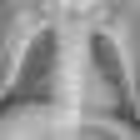

Prediction: Healthy
Ground Truth: Healthy


In [39]:
import random
from IPython.display import display

index = random.randint(0, len(test_dataset))

x, y = test_dataset[index]
display(x.resize((140, 140)))
x = np.array(x)
L = x.shape[0] * x.shape[1]
x = x.reshape(1, 1, L)/255.
pred = model(x)

pred = pred.squeeze(0).squeeze(0)
pred[pred>=0.5] = 1
pred[pred<0.5] = 0
print("Prediction: Pneumonia" if pred[0] else "Prediction: Healthy")
print("Ground Truth: Pneumonia" if y[0] else "Ground Truth: Healthy")